In [1]:
from kaveh.behavioral.oculomotor.session import session
from kaveh.toolbox import find_file
from neo.io import Spike2IO
from matplotlib import pyplot as plt
import numpy as np
import quantities as pq
import csv
import os
import fnmatch
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
    
from matplotlib import style
style.use('bmh')
COLOR = 'gray'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [132]:
def bin_error_dirs(error_dirs):
    '''
    Bin error directions: Bins start from 157.5 and increaments counter-clockwise every 45 degrees => 8 bins, 0 to 7
    '''
    bins = np.arange(-180 + 22.5, 180, 45)
    bin_ind = np.digitize(error_dirs , bins, right=True)
    bin_ind[bin_ind == 8] = 0
    return bins, bin_ind


import quantities as pq

def get_bin_cs_counts(cs_range, event_times, bin_ind, error_dir_bin_numbers, cs_times):
    '''
    get cs_counts for each bin
    '''
#     cs_range = pq.quantity.Quantity(cs_range, 's')
    bin_cs_counts = []
    bin_cs_prob = []
    bin_size = []
    for ebn in error_dir_bin_numbers:
        bin_times = event_times[bin_ind == ebn]
        cs_count = 0
        if bin_times.size != 0:
            for bt in bin_times:
                cs_count = cs_count + np.count_nonzero(np.where(np.logical_and(cs_times < bt+cs_range, cs_times > bt )))
            cs_prob = cs_count*1.0/bin_times.size
            bin_cs_prob.append(cs_prob)
            bin_cs_counts.append(cs_count)
            bin_size.append(bin_times.size)
        else:
            bin_cs_counts.append(0)
            bin_cs_prob.append(0)
            bin_size.append(0)
        
    bin_cs_counts = np.array(bin_cs_counts)
    bin_cs_prob = np.array(bin_cs_prob)
    bin_size = np.array(bin_size)
#     bin_cs_counts = bin_cs_counts*1.0/np.sum(bin_cs_counts)
    return (bin_cs_counts, bin_cs_prob, bin_size)

In [309]:
def get_cs_on_off_indices(cs_on, error_dir):
    if cs_on == 180:
        cs_on_indices = np.where(np.logical_or(error_dir >= 135 , error_dir <= -135))
    if cs_on == -135:
        cs_on_indices = np.where(np.logical_and(error_dir >= -180 , error_dir <= -90))
    if cs_on == -90:
        cs_on_indices = np.where(np.logical_and(error_dir >= -135 , error_dir <= -45))
    if cs_on == -45:
        cs_on_indices = np.where(np.logical_and(error_dir >= -90 , error_dir <=0))
    if cs_on == 0:
        cs_on_indices = np.where(np.logical_and(error_dir >= -45 , error_dir <= 45))
    if cs_on == 45:
        cs_on_indices = np.where(np.logical_and(error_dir >= 0 , error_dir <= 90))
    if cs_on == 90:
        cs_on_indices = np.where(np.logical_and(error_dir >= 45  , error_dir <= 135))
    if cs_on == 135:
        cs_on_indices = np.where(np.logical_and(error_dir >= 90 , error_dir <= 180))
    return cs_on_indices


In [4]:
with open('../data/david_neurs.csv', 'r') as csv_f:
    reader = csv.reader(csv_f)
    csv_content = np.array(list(reader))
neuron_names = np.array([fn[0].split('\t')[0].split('\t')[0] for fn in csv_content if fn[0][-1][-1] == '1'])

file_names = []
for nn in neuron_names:
    matches = []
    for root, dirnames, filenames in os.walk('../data/david_neurons/' + nn):
        for filename in fnmatch.filter(filenames, '*.smr.pkl'):
            matches.append(os.path.join(root, filename))
    if matches:
        for ff in matches:
            if os.path.exists(ff+'.GMM.CS.csv'):
                file_names.append(os.path.basename(ff)[0:-4])

# List of files with adapt/Adapt in their filenames 
adapt_filenames = [fb for fb in file_names if any(s in fb for s in ('adapt','Adapt') if 'PreAdapt' not in fb and 'Preadapt' not in fb)]
               

In [5]:
def calc_saccade_reaction_time_to_target_offset(session, target_offset_indices_to_include):
    saccade_rt = []
    saccade_rt_target_offset_times = []
    saccade_rt_target_offset_indices = []
    
    for toff, i in zip(session.target_offset_times[target_offset_indices_to_include], target_offset_indices_to_include):
    
        delay_to_next_saccade = session.saccade_onset_times[np.argmax(session.saccade_onset_times > toff)] - toff
        delay_to_next_target_jump = session.target_onset_times[np.argmax(session.target_onset_times > toff)] - toff
        # Only consider reaction times that are less than 600ms and are occurring before the next target jump
        if delay_to_next_saccade <= delay_to_next_target_jump and delay_to_next_saccade <= 0.6 and delay_to_next_saccade>=0:
            saccade_rt.append(delay_to_next_saccade)
            saccade_rt_target_offset_times.append(toff)
            saccade_rt_target_offset_indices.append(i)

    saccade_rt = np.squeeze(np.array(saccade_rt))  # reaction times
    saccade_rt_target_offset_times = np.squeeze(np.array(saccade_rt_target_offset_times)) # target offset times for which the reaction times were calculated
    saccade_rt_target_offset_indices = np.squeeze(np.array(saccade_rt_target_offset_indices)) # indices of target offset times for which the reaction times were calculated
    
    return (saccade_rt, saccade_rt_target_offset_times, saccade_rt_target_offset_indices)

    

In [6]:
f_index = [4,11,12,14,16,17,18,20,21,22,23,24,25,28,31,32,33,34,35, 36]

In [7]:
adapt_filenames = [adapt_filenames[i] for i in f_index]

In [8]:
adapt_filenames

['K25_1HadaptBOTHBW.smr',
 'W120508_1_1429_Adapt.smr',
 'W120508_2_1548_Adapt.smr',
 'W120208_1_1428_Adapt.smr',
 'F112006_1501_Adapt.smr',
 'F101106_1324_Adapt.smr',
 'F102006_0933_Adapt.smr',
 'F110706_1421_Adapt.smr',
 'F102706_1449_Adapt.smr',
 'F101606_1323_Adapt.smr',
 'F110206_1411_Adapt.smr',
 'B101308_1351_Adapt.smr',
 'B101308_1443_AdaptForward.smr',
 'B091608_1306_AdaptForward.smr',
 'B091208_1554_Adapt.smr',
 'B100308_2_1504_AdaptForward.smr',
 'B100308_2_1412_Adapt.smr',
 'B093008_1242_AdaptForward.smr',
 'B093008_1200_Adapt.smr',
 'B091908_1_1509_Adapt.smr']

In [9]:
# adapt_filenames = [adapt_filenames[0]]

In [10]:
# f_index = [0,1,6,7,8,11,13,15,16,17,18,19]

# adapt_filenames = [adapt_filenames[i] for i in f_index]

In [335]:
# dont include: 0,1,2,27
# 5 is fine but half the session target jump is 1 degrees => not detected
# 6,7,8,9,10,13,15, 19,26,27,29, 36 fine but doesn't seem to be in cs_on/off axis
# 30: look at the detected complex spikes
cs_prob_on_for_file={}
cs_prob_off_for_file = {}
cs_prob_for_file = {}

cs_count_on_for_file={}
cs_count_off_for_file = {}
cs_count_for_file = {}

bin_size_on_for_file={}
bin_size_off_for_file = {}
bin_size_for_file = {}

rt_mean_on_for_file={}
rt_std_on_for_file={}

rt_mean_off_for_file={}
rt_std_off_for_file={}

rt_mean_for_file={}
rt_std_for_file={}

error_mag_for_file={}
error_dir_for_file={}

saccade_rt_on_for_file = {}
saccade_rt_off_for_file = {}

for ii, f_name in enumerate(adapt_filenames):
    # f_name = adapt_filenames[37]
    f_name_smr = find_file(os.path.basename(f_name), '../data/david_neurons')
    f_name_session = find_file(os.path.basename(f_name)+'.pkl.session.pkl', '../data/david_neurons')
    f_name_csv = find_file(os.path.basename(f_name)+'.pkl.GMM.CS.csv', '../data/david_neurons')

    print(ii, f_name)
    with open(f_name_session, 'rb') as input:
        try:
            mysess = pickle.load(input, encoding='latin1')
        except TypeError:
            mysess = pickle.load(input)

    iss_range = pq.quantity.Quantity(0.025, 's')
    iss_targets = []
    iss_saccades = []
    saccades_with_no_iss_target = []
    for i, (son, soff) in enumerate(zip(mysess.saccade_onset_times, mysess.saccade_offset_times)):
    #     iss_targets.append(np.where(np.logical_or(np.logical_and(mysess.target_onset_times < son + iss_range, 
    #                                                              mysess.target_onset_times > son - iss_range), 
    #                                               np.logical_and(mysess.target_offset_times < soff + iss_range, 
    #                                                              mysess.target_offset_times > soff - iss_range)))[0])
        iss_targets.append(np.where(np.logical_and(mysess.target_onset_times > son - iss_range , mysess.target_offset_times < soff + iss_range))[0])
        if iss_targets[-1].size != 0:
            iss_saccades.append(i)
        if iss_targets[-1].size == 0:
            saccades_with_no_iss_target.append(i)

    iss_targets = np.squeeze(np.array([isst[0] for isst in iss_targets if isst.size != 0]))
    iss_saccades = np.squeeze(iss_saccades)
    non_iss_target_jumps = np.setdiff1d(np.arange(mysess.target_onset_times.size), iss_targets)


    saccade_rt = []
    saccade_rt_sac_offset_times = []
    saccade_rt_sac_offset_indices = []
    error_mag = []
    error_dir = []
    for i, soff in enumerate(mysess.saccade_offset_times[iss_saccades]):

        delay_to_next_saccade = mysess.saccade_onset_times[np.argmax(mysess.saccade_onset_times > soff)] - soff
        delay_to_next_target_jump = mysess.target_onset_times[np.argmax(mysess.target_onset_times > soff)] - soff
        e_mag = mysess.error_mag[iss_saccades][i]
        e_dir = mysess.error_dir[iss_saccades][i]
        # Only consider reaction times that are less than 600ms and are occurring before the next target jump
        if delay_to_next_saccade <= delay_to_next_target_jump and delay_to_next_saccade <= 0.6 and delay_to_next_saccade>=0.005 and e_mag > 1:
            saccade_rt.append(delay_to_next_saccade)
            saccade_rt_sac_offset_times.append(soff)
            saccade_rt_sac_offset_indices.append(i)
            error_mag.append(e_mag)
            error_dir.append(e_dir)

    saccade_rt = np.squeeze(np.array(saccade_rt))
    saccade_rt_sac_offset_times = np.squeeze(np.array(saccade_rt_sac_offset_times))
    saccade_rt_sac_offset_indices = np.squeeze(np.array(saccade_rt_sac_offset_indices))
    error_mag = np.squeeze(np.array(error_mag))
    error_dir = np.squeeze(np.array(error_dir))
    
#     # find jump vectors' directions
#     toff_V = np.squeeze(mysess.VT[mysess.target_offsets])
#     ton_V = np.squeeze(mysess.VT[mysess.target_onsets])
#     jump_vec_V = toff_V - ton_V

#     toff_H = np.squeeze(mysess.HT[mysess.target_offsets])
#     ton_H = np.squeeze(mysess.HT[mysess.target_onsets])
#     jump_vec_H = toff_H - ton_H


#     jump_dir = np.arctan2(jump_vec_V, jump_vec_H)*180/np.pi

#     from sklearn.cluster import KMeans
#     kmeans = KMeans(n_clusters = 2).fit(error_dir.reshape(-1,1))

    # Load voltage
    from neo.io import Spike2IO

    neo_reader = Spike2IO(filename=f_name_smr)
    neo_data = neo_reader.read()
    data_block = neo_data[0]
    seg = data_block.segments[0]
    events = seg.events

    
    t_signal = seg.analogsignals[-1].times
    signal_fs = seg.analogsignals[-1].sampling_rate

    with open(f_name_csv, 'r') as csv_f:
        reader = csv.reader(csv_f)
        csv_content = np.array(list(reader), dtype=np.int64)

    cs_indices = np.squeeze(csv_content[np.where(csv_content[:,1] == 1), 0])
    cs_times = t_signal[cs_indices]
    
    # get cs_prob for each cluster

#     cs_range = pq.quantity.Quantity(0.200, 's')
#     cs_prob = [0,0]
#     d = 0
#     cs_count = 0
#     for toff in mysess.saccade_offset_times[iss_saccades][saccade_rt_sac_offset_indices][kmeans.labels_== d]:
#         cs_count = cs_count + np.count_nonzero(np.where(np.logical_and(cs_times < toff+cs_range, cs_times > toff )))    
#     cs_prob[d] = cs_count*1.0/np.count_nonzero(kmeans.labels_ == d)

#     d = 1
#     cs_count = 0
#     for toff in mysess.saccade_offset_times[iss_saccades][saccade_rt_sac_offset_indices][kmeans.labels_== d]:
#         cs_count = cs_count + np.count_nonzero(np.where(np.logical_and(cs_times < toff+cs_range, cs_times > toff )))    
#     cs_prob[d] = cs_count*1.0/np.count_nonzero(kmeans.labels_ == d)
#     print(cs_prob)
#     cs_on = np.argmax(cs_prob)
#     print('CS-on is cluster {}'.format(cs_on))
#     cs_off = 1-cs_on
    bins, err_dir_ind = bin_error_dirs(error_dir)
    bin_centers = ((bins[:-1] + bins[1:]) / 2)
    bin_centers = np.hstack(([180], bin_centers))
    (cs_counts, cs_probs, bin_sizes) = get_bin_cs_counts(0.180, saccade_rt_sac_offset_times, err_dir_ind, range(8), cs_times)
    top2 = np.argsort(bin_sizes)[-2:][::-1]
    cs_on = np.argmax(cs_probs[top2])
    cs_off = np.argmin(cs_probs[top2])
    cs_on = bin_centers[top2[cs_on]]
    cs_off = bin_centers[top2[cs_off]]
    cs_on_indices = get_cs_on_off_indices(cs_on, error_dir)[0]
    cs_off_indices = get_cs_on_off_indices(cs_off, error_dir)[0]

    print("----------------------------------")
    print("cs_on = {}".format(cs_on))
    print(cs_on_indices.shape)
    print("cs_off = {}".format(cs_off))
    print(cs_off_indices.shape)
#     print(cs_on_indices.shape)
#     print(cs_off_indices.shape)
#     print(bin_sizes)
#     print(cs_on)
    print("----------------------------------")
    # Reaction times from primary saccade offset to corrective saccade onset:
#     (rt_iss, rt_toffs_iss, rt_toff_indices_iss) = calc_saccade_reaction_time_to_target_offset(mysess, iss_targets)
        
    
#     rt_toff_indices_iss_cs_on = np.intersect1d(rt_toff_indices_iss, np.where(kmeans.labels_ == cs_on), return_indices=True)[1]
#     rt_toff_indices_iss_cs_off = np.intersect1d(rt_toff_indices_iss, np.where(kmeans.labels_ == cs_off), return_indices=True)[1]
#     rt_iss_cs_on = rt_iss[rt_toff_indices_iss_cs_on]
#     rt_iss_cs_off = rt_iss[rt_toff_indices_iss_cs_off]
#     rt_toffs_iss_cs_on = rt_toffs_iss[rt_toff_indices_iss_cs_on]
#     rt_toffs_iss_cs_off = rt_toffs_iss[rt_toff_indices_iss_cs_off]
    
    # bin based on quartile for each category of cs_on cs_off and all
    bin_edges = [np.percentile(saccade_rt[cs_on_indices],q) for q in [25, 50, 70, 85, 90]]
    bin_ind_sac_delays = np.digitize(saccade_rt[cs_on_indices], bins = bin_edges)
    rt_mean_on_for_file[f_name] = [np.mean(saccade_rt[cs_on_indices][bin_ind_sac_delays == i]) for i in range(len(bin_edges)+1)]
    rt_std_on_for_file[f_name] = [np.std(saccade_rt[cs_on_indices][bin_ind_sac_delays == i]) for i in range(len(bin_edges)+1)]
    (cs_counts_on, cs_probs_on, bin_sizes_on) = get_bin_cs_counts(0.180, saccade_rt_sac_offset_times[cs_on_indices], bin_ind_sac_delays, range(len(bin_edges)+1), cs_times)
    
    
    bin_edges = [np.percentile(saccade_rt[cs_off_indices],q) for q in [25, 50, 70, 85, 90]]
    bin_ind_sac_delays = np.digitize(saccade_rt[cs_off_indices], bins = bin_edges)
    rt_mean_off_for_file[f_name] = [np.mean(saccade_rt[cs_off_indices][bin_ind_sac_delays == i]) for i in range(len(bin_edges)+1)]
    rt_std_off_for_file[f_name] = [np.std(saccade_rt[cs_off_indices][bin_ind_sac_delays == i]) for i in range(len(bin_edges)+1)]
    (cs_counts_off, cs_probs_off, bin_sizes_off) = get_bin_cs_counts(0.180, saccade_rt_sac_offset_times[cs_off_indices], bin_ind_sac_delays, range(len(bin_edges)+1), cs_times)

#     bin_edges = [np.percentile(rt_iss_cs_off,q) for q in [25, 50, 75]]
#     bin_ind_sac_delays = np.digitize(rt_non_iss_cs_off, bins = bin_edges)
#     rt_mean_off_for_file[f_name] = [np.mean(rt_iss_cs_off[bin_ind_sac_delays == i]) for i in range(len(bin_edges)+1)]
#     rt_std_off_for_file[f_name] = [np.std(rt_iss_cs_off[bin_ind_sac_delays == i]) for i in range(len(bin_edges)+1)]
#     (cs_counts_off, cs_probs_off, bin_sizes_off) = get_bin_cs_counts(0.200, rt_toffs_iss_cs_off, bin_ind_sac_delays, np.unique(bin_ind_sac_delays), cs_times)

#     bin_edges = [np.percentile(rt_iss,q) for q in [25, 50, 75]]
#     bin_ind_sac_delays = np.digitize(rt_iss, bins = bin_edges)
#     rt_mean_for_file[f_name] = [np.mean(rt_iss[bin_ind_sac_delays == i]) for i in range(len(bin_edges)+1)]
#     rt_std_for_file[f_name] = [np.std(rt_iss[bin_ind_sac_delays == i]) for i in range(len(bin_edges)+1)]
#     (cs_counts, cs_probs, bin_sizes) = get_bin_cs_counts(0.200, rt_toffs_iss, bin_ind_sac_delays, np.unique(bin_ind_sac_delays), cs_times)
    
    
#     # fixed bins
#     bin_edges = np.arange(0.1,0.6,0.1)
#     bin_ind_sac_delays = np.digitize(rt_non_iss_cs_on, bins = bin_edges)
#     (cs_counts_on, cs_probs_on, bin_sizes_on) = get_bin_cs_counts(0.200, rt_toffs_non_iss_cs_on, bin_ind_sac_delays, np.arange(0,len(bin_edges)+1), cs_times)

#     bin_ind_sac_delays = np.digitize(rt_non_iss_cs_off, bins = bin_edges)
#     (cs_counts_off, cs_probs_off, bin_sizes_off) = get_bin_cs_counts(0.200, rt_toffs_non_iss_cs_off, bin_ind_sac_delays, np.arange(0,len(bin_edges)+1), cs_times)

#     bin_ind_sac_delays = np.digitize(rt_non_iss, bins = bin_edges)
#     (cs_counts, cs_probs, bin_sizes) = get_bin_cs_counts(0.200, rt_toffs_non_iss, bin_ind_sac_delays, np.arange(0,len(bin_edges)+1), cs_times)
    
    
    
#     plt.figure(figsize=(8,5))
#     labels = ['CS_on: {} deg'.format(np.rint(kmeans.cluster_centers_[cs_on])), 'CS_off: {} deg'.format(np.rint(kmeans.cluster_centers_[cs_off]))]
#     for i, rt in enumerate([rt_non_iss_cs_on, rt_non_iss_cs_off]):
#         hs, bins = np.histogram(rt, bins = np.arange(0,0.6 , 0.01))
#     #     hs = (hs*1.0/np.sum(hs))
#         center = (bins[:-1] + bins[1:]) / 2
#         plt.bar(center, hs, width=0.01, alpha = 0.5, label=labels[i])
#     plt.legend()
#     plt.title('Distribution of reaction {}'.format(f_name))
#     plt.xlabel('Reaction time')
#     plt.ylabel('Count')
    
#     plt.savefig('../data/plots/cs-on-off-rxn-distro/cs_on_cs_off_'+f_name+'.png')
#     plt.close()
    cs_prob_on_for_file[f_name] = cs_probs_on
    cs_prob_off_for_file[f_name] = cs_probs_off
#     cs_prob_for_file[f_name] = cs_probs
    
    cs_count_on_for_file[f_name] = cs_counts_on
    cs_count_off_for_file[f_name] = cs_counts_off
#     cs_count_for_file[f_name] = cs_counts

    bin_size_on_for_file[f_name] = bin_sizes_on
    bin_size_off_for_file[f_name] = bin_sizes_off
#     bin_size_for_file[f_name] = bin_sizes
    
#     error_mag_for_file[f_name] = error_mag
#     error_dir_for_file[f_name] = error_dir
    saccade_rt_on_for_file[f_name] = saccade_rt[cs_on_indices]
    saccade_rt_off_for_file[f_name] = saccade_rt[cs_off_indices]

(0, 'K25_1HadaptBOTHBW.smr')
----------------------------------
cs_on = 0.0
(210,)
cs_off = 180.0
(221,)
----------------------------------
(1, 'W120508_1_1429_Adapt.smr')
----------------------------------
cs_on = 180.0
(516,)
cs_off = 0.0
(406,)
----------------------------------
(2, 'W120508_2_1548_Adapt.smr')
----------------------------------
cs_on = 180.0
(478,)
cs_off = 0.0
(451,)
----------------------------------
(3, 'W120208_1_1428_Adapt.smr')
----------------------------------
cs_on = -45.0
(450,)
cs_off = 135.0
(337,)
----------------------------------
(4, 'F112006_1501_Adapt.smr')
----------------------------------
cs_on = -90.0
(580,)
cs_off = 90.0
(654,)
----------------------------------
(5, 'F101106_1324_Adapt.smr')
----------------------------------
cs_on = 180.0
(746,)
cs_off = 0.0
(356,)
----------------------------------
(6, 'F102006_0933_Adapt.smr')
----------------------------------
cs_on = 180.0
(386,)
cs_off = 0.0
(196,)
----------------------------------
(7, '

In [116]:
# plt.rcParams['xtick.color'] = 'black'
# plt.figure()
# for fn, srt, em in zip(saccade_rt_for_file.keys(), saccade_rt_for_file.values(), error_mag_for_file.values()):
#     plt.hist(srt,  np.arange(0,0.4,0.01))
#     plt.title('srt ' + fn, color = 'black')
#     plt.savefig('../data/plots/tmp/' + fn + '.srt.png')
#     plt.cla()
#     plt.hist(em , bins=np.arange(0,15,0.1))
#     plt.title('em' + fn, color = 'black')
#     plt.savefig('../data/plots/tmp/' + fn + '.emag.png')
#     plt.cla()
            

In [336]:
# plt.figure()
# plt.rcParams['xtick.color'] = 'black'
# plt.rcParams['ytick.color'] = 'black'
# for fn, ed in zip(error_dir_for_file.keys(), error_dir_for_file.values()):
#     bins, err_dir_ind = bin_error_dirs(ed )
# #     bin_centers = ((bins[:-1] + bins[1:]) / 2)
    
#     for i in np.unique(err_dir_ind):
        
#         plt.bar(i, np.count_nonzero(err_dir_ind==i))
# #         plt.xticks(range(8), np.hstack((bin_centers, [180])))

#     plt.title('ed' + fn, color='black')
#     plt.savefig('../data/plots/tmp/error_dir/' + fn + '.ed.png')
#     plt.cla()
    
    

In [338]:
# calc cs probability across all data - fixed bin edges
# cs_count_mat = np.array([s for s in cs_count_for_file.values()])
cs_count_on_mat = np.array([s for s in cs_count_on_for_file.values()])
cs_count_off_mat = np.array([s for s in cs_count_off_for_file.values()])

# bin_size_mat = np.array([s for s in bin_size_for_file.values()])
bin_size_on_mat = np.array([s for s in bin_size_on_for_file.values()])
bin_size_off_mat = np.array([s for s in bin_size_off_for_file.values()])

cs_prob_on_mat = np.array([s for s in cs_prob_on_for_file.values()])
cs_prob_off_mat = np.array([s for s in cs_prob_off_for_file.values()])

cs_prob_on_mean = np.mean(cs_prob_on_mat, axis = 0)
cs_prob_on_se = np.std(cs_prob_on_mat, axis = 0)/np.sqrt(cs_prob_on_mat.shape[0])
rt_mean_on_mat = np.array([s for s in rt_mean_on_for_file.values()])

cs_prob_off_mean = np.mean(cs_prob_off_mat, axis = 0)
cs_prob_off_se = np.std(cs_prob_off_mat, axis = 0)/np.sqrt(cs_prob_off_mat.shape[0])
rt_mean_off_mat = np.array([s for s in rt_mean_off_for_file.values()])


In [97]:
# cs_tuning = np.true_divide(np.sum(cs_count_on_mat, axis=0),np.sum(bin_size_on_mat, axis=0))

In [98]:
# bin_size_normalized  = np.sum(bin_size_on_mat, axis=0)*1.0/np.sum(np.sum(bin_size_on_mat, axis=0))

In [99]:
# plt.figure()
# plt.plot(cs_tuning)
# plt.plot(bin_size_normalized)

In [100]:
# calc. mean of cs probabilities across sessions - within session quartile bin edges
# cs_prob_mat = np.array([s for s in cs_prob_for_file.values()])
# cs_prob_on_mat = np.array([s for s in cs_prob_on_for_file.values()])
# cs_prob_off_mat = np.array([s for s in cs_prob_off_for_file.values()])

# rt_mean_mat = np.array([s for s in rt_mean_for_file.values()])
# rt_mean_on_mat = np.array([s for s in rt_mean_on_for_file.values()])
# rt_mean_off_mat = np.array([s for s in rt_mean_on_for_file.values()])

# cs_prob_on_mean = np.mean(cs_prob_on_mat, axis = 0)
# cs_prob_on_se = np.std(cs_prob_on_mat, axis = 0)/np.sqrt(cs_prob_on_mat.shape[0])

# cs_prob_off_mean = np.mean(cs_prob_off_mat, axis = 0)
# cs_prob_off_se = np.std(cs_prob_off_mat, axis = 0)/np.sqrt(cs_prob_off_mat.shape[0])

In [339]:
rt_mean_on_mean = np.mean(rt_mean_on_mat, axis = 0)
rt_mean_on_se = np.std(rt_mean_on_mat, axis = 0)/np.sqrt(rt_mean_on_mat.shape[0])

rt_mean_off_mean = np.mean(rt_mean_off_mat, axis = 0)
rt_mean_off_se = np.std(rt_mean_off_mat, axis = 0)/np.sqrt(rt_mean_off_mat.shape[0])


<IPython.core.display.Javascript object>


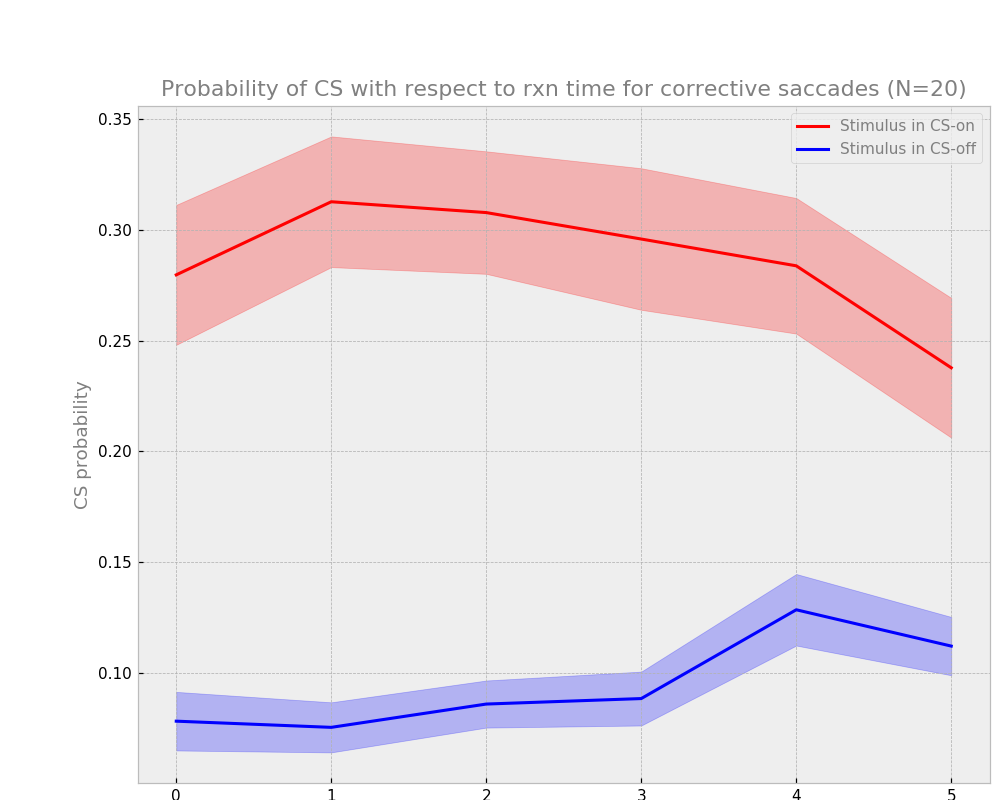

Text(0.5,1,u'Probability of CS with respect to rxn time for corrective saccades (N=20)')

In [342]:
center = range(len(bin_edges)+1)
f1 = plt.figure(figsize=(10,8))
plt.plot(cs_prob_on_mean, 'r')
plt.fill_between(center, cs_prob_on_mean - cs_prob_on_se, cs_prob_on_mean + cs_prob_on_se, color='r', alpha=0.25)

plt.plot(cs_prob_off_mean, 'b')
plt.fill_between(center, cs_prob_off_mean - cs_prob_off_se, cs_prob_off_mean + cs_prob_off_se, color='b', alpha=0.25)

# plt.xticks([0,1,2,3],['Q1','Q2','Q3','Q3'])
plt.xlabel('Saccade reaction time quartile')
plt.ylabel('CS probability')
plt.legend(['Stimulus in CS-on', 'Stimulus in CS-off'])
plt.title('Probability of CS with respect to rxn time for corrective saccades (N={})'.format(len(adapt_filenames)))


<IPython.core.display.Javascript object>


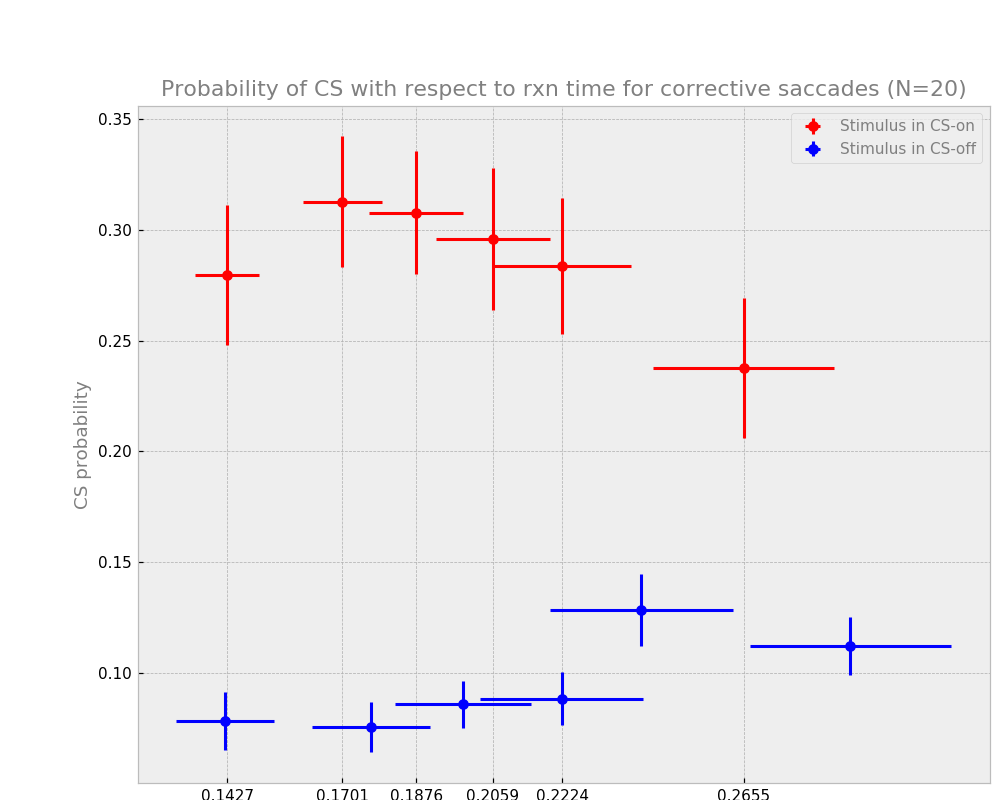

Text(0.5,1,u'Probability of CS with respect to rxn time for corrective saccades (N=20)')

In [343]:
f2 = plt.figure(figsize=(10,8))
plt.errorbar(rt_mean_on_mean, cs_prob_on_mean, yerr=cs_prob_on_se, xerr=rt_mean_on_se, fmt='o', color='r')
plt.errorbar(rt_mean_off_mean, cs_prob_off_mean, yerr=cs_prob_off_se, xerr=rt_mean_off_se, fmt='o', color='b')
plt.xticks(rt_mean_on_mean)
plt.xlabel('Saccade reaction time (s)')
plt.ylabel('CS probability')
plt.legend(['Stimulus in CS-on', 'Stimulus in CS-off'])
plt.title('Probability of CS with respect to rxn time for corrective saccades (N={})'.format(len(adapt_filenames)))

In [344]:
f1.savefig('../data/plots/Saliency_stuff/prob-cs-on-off-rxn-time-corrective-saccades_separate_on_off.png')
f2.savefig('../data/plots/Saliency_stuff/prob-cs-on-off-rt-error-bars-corrective-saccades_separate_on_off.png')